In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import numpy as np
import sklearn, sklearn.model_selection
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(1)

In [3]:
BATCH_SIZE = 64

In [4]:
mytransform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(100),
    torchvision.transforms.ToTensor()])

data = torchvision.datasets.ImageFolder("./cyclegan/results/brats2013_train/trainB", transform=mytransform)

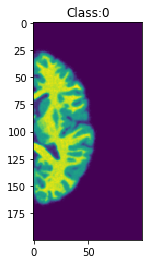

In [5]:
plt.imshow(data[100][0][0].numpy());
plt.title("Class:" + str(data[100][1]));

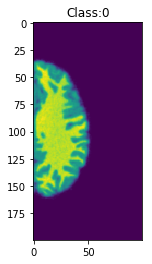

In [6]:
plt.imshow(data[0][0][0].numpy());
plt.title("Class:" + str(data[0][1]));

In [7]:
tosplit = np.asarray(data.imgs)[:,1]
idx = range(tosplit.shape[0])
train_idx, valid_idx = sklearn.model_selection.train_test_split(idx, stratify=tosplit, train_size=0.75, random_state=0)

/u/cohenjos/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
print "train_idx", len(train_idx)
print "valid_idx", len(valid_idx)

train_idx 756
valid_idx 252


In [9]:
train_loader = torch.utils.data.DataLoader(dataset=data, batch_size=BATCH_SIZE, 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(train_idx))
valid_loader = torch.utils.data.DataLoader(dataset=data, batch_size=len(valid_idx), 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(valid_idx))

In [10]:
valid_data = list(valid_loader)
valid_x = Variable(valid_data[0][0])
valid_y = valid_data[0][1]

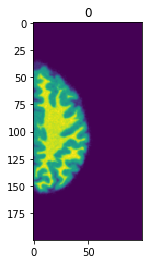

In [11]:
plt.imshow(valid_x[70][0].data.numpy());
plt.title(valid_y[70]);

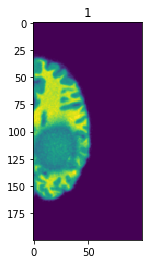

In [12]:
plt.imshow(valid_x[2][0].data.numpy());
plt.title(valid_y[2]);

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=64,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),            
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=32,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            nn.ReLU(), 
            #nn.MaxPool2d(kernel_size=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=16,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            nn.ReLU(), 
            #nn.MaxPool2d(kernel_size=2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=8,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            nn.ReLU(), 
            #nn.MaxPool2d(kernel_size=2),
        )
        self.out = nn.Linear(440, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        #x = self.bout(x)
        #x = self.dropout1(x)
        output = self.out(x)
        return output, x

In [14]:
cnn = CNN()
print(cnn)

CNN (
  (conv1): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU ()
  )
  (conv2): Sequential (
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU ()
  )
  (conv3): Sequential (
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU ()
  )
  (conv4): Sequential (
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU ()
  )
  (out): Linear (440 -> 2)
)


In [15]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(200):
    batch_loss = []
    for step, (x, y) in enumerate(train_loader):
        
        b_x = Variable(x)
        b_y = Variable(y)

        cnn.train()
        output = cnn(b_x)[0]
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.data[0])
    
    cnn.eval()
    test_output, last_layer = cnn(valid_x)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    accuracy = sum(pred_y == valid_y) / float(valid_y.size(0))
    print('Epoch: ', epoch, '| train loss: %.4f' % np.asarray(batch_loss).mean(), '| valid accuracy: %.2f' % accuracy)

In [94]:
#torch.save(cnn.state_dict(), "./classifier_model.pth")

In [16]:
checkpoint = torch.load("./classifier_model.pth")
cnn.load_state_dict(checkpoint)

In [17]:
cnn.eval()
test_output, last_layer = cnn(valid_x)
pred_y = torch.max(test_output, 1)[1].data.squeeze()
accuracy = sum(pred_y == valid_y) / float(valid_y.size(0))
print 'valid accuracy: %.2f' % accuracy

valid accuracy: 0.82


In [18]:
class SubsetSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):

        return len(self.indices)


In [19]:
import collections

In [272]:
results = []

for percent in ["0.0", 
                "0.1", 
                "0.2", 
                "0.3", 
                "0.4", 
                "0.5", 
                "0.6", 
                "0.7", 
                "0.8", 
                "0.9", 
                "1.0"]:
    
    path = "./cyclegan/results/brats2013_cyclegan_" + percent + "/test_latest/"
    test_data_raw = torchvision.datasets.ImageFolder(path, transform=mytransform)
    
    labels = np.asarray(["True" in img for img in np.asarray(test_data_raw.imgs)[:,0]])
    fake_b_samples = np.where(["fake_B" in img for img in np.asarray(test_data_raw.imgs)[:,0]])[0]
    real_b_samples = np.where(["real_B" in img for img in np.asarray(test_data_raw.imgs)[:,0]])[0]

    test_fake_b_loader = torch.utils.data.DataLoader(dataset=test_data_raw, batch_size=len(test_data_raw), shuffle=False, 
                                              sampler=SubsetSampler(fake_b_samples))
    test_real_b_loader = torch.utils.data.DataLoader(dataset=test_data_raw, batch_size=len(test_data_raw), shuffle=False, 
                                              sampler=SubsetSampler(real_b_samples))
    
    test_fake_b_data = list(test_fake_b_loader)
    test_real_b_data = list(test_real_b_loader)
    test_fake_b_x = Variable(test_fake_b_data[0][0])
    test_fake_b_y = test_fake_b_data[0][1]
    
    cnn.eval()
    r = cnn(test_fake_b_x)

    pred_y = torch.max(r[0], 1)[1].data.squeeze().numpy()
    
    acc = (pred_y == labels[fake_b_samples]).mean()
    
        
    dist_0 = pred_y[labels[fake_b_samples] == 0].mean()
    dist_1 = pred_y[labels[fake_b_samples] == 1].mean()
    
    
    diff = np.abs((test_fake_b_data[0][0].numpy() - test_real_b_data[0][0].numpy()))
    diff_per_image = diff.mean(axis=(1,2,3))
    
    diff_0 = diff_per_image[labels[fake_b_samples] == 0].mean()
    diff_1 = diff_per_image[labels[fake_b_samples] == 1].mean()


    results.append([percent, pred_y.mean(), acc, dist_0, dist_1, collections.Counter(pred_y), diff_0, diff_1])
    
    print "Percent:", percent," Tumors:", pred_y.mean(), " ", collections.Counter(pred_y), " ", diff_0, diff_1

Percent: 0.0  Tumors: 0.2857142857142857   Counter({0: 215, 1: 86})   0.012405297 0.024879461
Percent: 0.1  Tumors: 0.32558139534883723   Counter({0: 203, 1: 98})   0.014064076 0.024477163
Percent: 0.2  Tumors: 0.6079734219269103   Counter({1: 183, 0: 118})   0.016086772 0.020394633
Percent: 0.3  Tumors: 0.5714285714285714   Counter({1: 172, 0: 129})   0.012966526 0.017943121
Percent: 0.4  Tumors: 0.5946843853820598   Counter({1: 179, 0: 122})   0.012642237 0.01617099
Percent: 0.5  Tumors: 0.5913621262458472   Counter({1: 178, 0: 123})   0.012945567 0.016981408
Percent: 0.6  Tumors: 0.6478405315614618   Counter({1: 195, 0: 106})   0.0136630535 0.017497813
Percent: 0.7  Tumors: 0.6677740863787376   Counter({1: 201, 0: 100})   0.016530378 0.019869745
Percent: 0.8  Tumors: 0.6578073089700996   Counter({1: 198, 0: 103})   0.013892662 0.017105188
Percent: 0.9  Tumors: 0.6910299003322259   Counter({1: 208, 0: 93})   0.015256999 0.017871996
Percent: 1.0  Tumors: 0.6976744186046512   Counter({

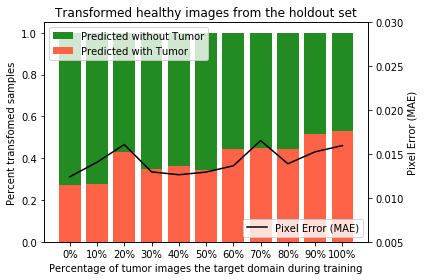

In [273]:
perc = np.asarray(results)[:,3].astype(np.float)
fig, ax1 = plt.subplots()
ax1.bar(range(perc.shape[0]), 1-perc, bottom=perc,color="forestgreen", label="Predicted without Tumor");
ax1.bar(range(perc.shape[0]), perc, color="tomato", label="Predicted with Tumor");
ax1.set_ylabel("Percent transfomed samples")
ax1.set_xlabel("Percentage of tumor images the target domain during training");
ax1.set_xticks(range(11), ["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])
ax1.set_title("Transformed healthy images from the holdout set"); # (GT=False)
ax1.legend(loc="upper left");

ax2 = ax1.twinx()
t = np.arange(11)
s2 = np.asarray(results)[:,6].astype(np.float)
ax2.set_ylim(ymax = 0.03, ymin = 0.005)
ax2.plot(t, s2, 'black', label="Pixel Error (MAE)")

ax2.set_ylabel('Pixel Error (MAE)')
ax2.legend(loc="lower right");
fig.tight_layout()
plt.xticks(range(11), ["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])
plt.show()

In [274]:
#l1_error[0,:,4].astype(np.float)

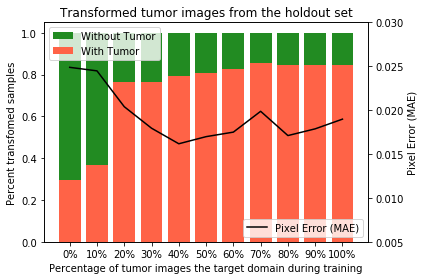

In [275]:
perc = np.asarray(results)[:,4].astype(np.float)
fig, ax1 = plt.subplots()
ax1.bar(range(perc.shape[0]), 1-perc, bottom=perc,color="forestgreen", label="Without Tumor");
ax1.bar(range(perc.shape[0]), perc, color="tomato", label="With Tumor");
ax1.set_ylabel("Percent transfomed samples")
ax1.set_xlabel("Percentage of tumor images the target domain during training");
ax1.set_title("Transformed tumor images from the holdout set"); # (GT=False)
ax1.legend(loc="upper left");

ax2 = ax1.twinx()
t = np.arange(11)
s2 = np.asarray(results)[:,7].astype(np.float)
ax2.set_ylim(ymax = 0.03, ymin = 0.005)
ax2.plot(t, s2, 'black', label="Pixel Error (MAE)")

ax2.set_ylabel('Pixel Error (MAE)')
#ax2.tick_params('y', colors='r')
ax2.legend(loc="lower right");
fig.tight_layout()
plt.xticks(range(11), ["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])
plt.show()

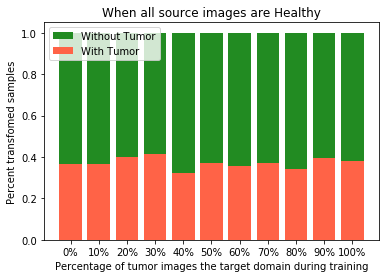

In [262]:
perc = np.asarray(results)[:,3].astype(np.float)
plt.bar(range(perc.shape[0]), 1-perc, bottom=perc,color="forestgreen", label="Without Tumor");
plt.bar(range(perc.shape[0]), perc, color="tomato", label="With Tumor");
plt.ylabel("Percent transfomed samples")
plt.xlabel("Percentage of tumor images the target domain during training");
plt.xticks(range(11), ["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])
plt.title("When all source images are Healthy"); # (GT=False)
plt.legend(loc="upper left");

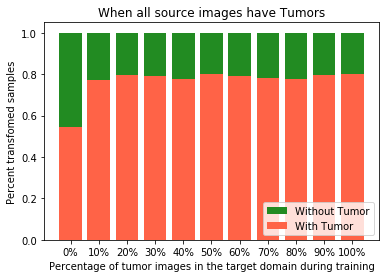

In [138]:
perc = np.asarray(results)[:,4].astype(np.float)
plt.bar(range(perc.shape[0]), 1-perc, bottom=perc,color="forestgreen", label="Without Tumor");
plt.bar(range(perc.shape[0]), perc, color="tomato", label="With Tumor");
plt.ylabel("Percent transfomed samples")
plt.xlabel("Percentage of tumor images in the target domain during training");
plt.xticks(range(11), ["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])
plt.title("When all source images have Tumors"); # (GT=False)
plt.legend(loc="lower right");

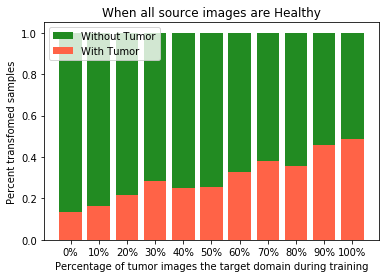

In [692]:
perc = np.asarray(results)[:,3].astype(np.float)
plt.bar(range(perc.shape[0]), 1-perc, bottom=perc,color="forestgreen", label="Without Tumor");
plt.bar(range(perc.shape[0]), perc, color="tomato", label="With Tumor");
plt.ylabel("Percent transfomed samples")
plt.xlabel("Percentage of tumor images the target domain during training");
plt.xticks(range(11), ["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])
plt.title("When all source images are Healthy"); # (GT=False)
plt.legend(loc="upper left")

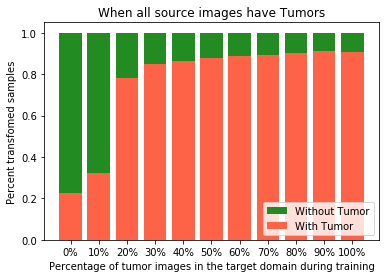

In [693]:
perc = np.asarray(results)[:,4].astype(np.float)
plt.bar(range(perc.shape[0]), 1-perc, bottom=perc,color="forestgreen", label="Without Tumor");
plt.bar(range(perc.shape[0]), perc, color="tomato", label="With Tumor");
plt.ylabel("Percent transfomed samples")
plt.xlabel("Percentage of tumor images in the target domain during training");
plt.xticks(range(11), ["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])
plt.title("When all source images have Tumors"); # (GT=False)
plt.legend(loc="lower right")

In [695]:
torch.save(cnn.state_dict(), "./classifier_model.pth")